<a href="https://colab.research.google.com/github/Sreyas2403/StockAnalysis_Patterns-Indicators/blob/main/MACD_TURN_Up%26Down_Assign8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nsepython

In [ ]:
from nsepython import *
print(indices)

['NIFTY', 'FINNIFTY', 'BANKNIFTY']


In [ ]:
symbol = 'SBIN'
series = 'EQ'
start_date = '01-01-2023'
end_date = '31-12-2023'
equity_data = equity_history(symbol, series,
                   start_date, end_date)
print(equity_data)

{'data': [{'_id': '642835e7faf76300072ef1db', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 557.25, 'CH_TRADE_LOW_PRICE': 546.5, 'CH_OPENING_PRICE': 546.5, 'CH_CLOSING_PRICE': 553.05, 'CH_LAST_TRADED_PRICE': 552.9, 'CH_PREVIOUS_CLS_PRICE': 550.8, 'CH_TOT_TRADED_QTY': 13824475, 'CH_TOT_TRADED_VAL': 7656154646.75, 'CH_52WEEK_HIGH_PRICE': 629.55, 'CH_52WEEK_LOW_PRICE': 425, 'CH_TOTAL_TRADES': 179516, 'CH_ISIN': 'INE062A01020', 'CH_TIMESTAMP': '2023-02-10', 'TIMESTAMP': '2023-02-09T18:30:00.000Z', 'createdAt': '2023-04-01T13:47:19.650Z', 'updatedAt': '2023-04-01T13:47:19.650Z', '__v': 0, 'SLBMH_TOT_VAL': None, 'VWAP': 553.81, 'mTIMESTAMP': '10-Feb-2023'}, {'_id': '63e4e0621df6cc0007b3d3dd', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 552, 'CH_TRADE_LOW_PRICE': 542.8, 'CH_OPENING_PRICE': 552, 'CH_CLOSING_PRICE': 550.8, 'CH_LAST_TRADED_PRICE': 551, 'CH_PREVIOUS_CLS_PRICE': 549.75, 'CH_TOT_TRADED_QTY': 15061047,

In [ ]:
import pandas as pd
import numpy as np
import nsepython as nse
import matplotlib.pyplot as plt

# Load stock names from an Excel file
file_path = '/content/Stocks.xlsx'  # place the file path
stock_names_df = pd.read_excel(file_path)
stock_names = stock_names_df['STOCK'].tolist()  # Assuming column A has the stock names

# Define date range
start_date = input()
end_date = input()

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD and Signal Line
def calculate_macd(data, slow=26, fast=12, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# Function to identify MACD turning points
def identify_macd_turning_points(df):
    upwards_macd = []
    downwards_macd = []
    for i in range(1, len(df)):
        # MACD turns upwards and is below Signal Line
        if df['MACD'][i] > df['MACD'][i-1] and df['MACD'][i-1] < df['MACD'][i-2] and df['MACD'][i] < df['Signal Line'][i]:
            upwards_macd.append((df['mTIMESTAMP'][i], df['RSI'][i], df['MACD'][i]))
        # MACD turns downwards and is above Signal Line
        if df['MACD'][i] < df['MACD'][i-1] and df['MACD'][i-1] > df['MACD'][i-2] and df['MACD'][i] > df['Signal Line'][i]:
            downwards_macd.append((df['mTIMESTAMP'][i], df['RSI'][i], df['MACD'][i]))
    return upwards_macd, downwards_macd

# Placeholder for results
results = []

# Process each stock
for stock_symbol in stock_names:
    try:
        # Fetch equity history for the stock symbol
        equity_data = nse.equity_history(stock_symbol, "EQ", start_date, end_date)
        stock_df = pd.DataFrame(equity_data)
        stock_df['mTIMESTAMP'] = pd.to_datetime(stock_df['mTIMESTAMP'])
        stock_df = stock_df.sort_values(by='mTIMESTAMP')

        # Convert necessary columns to numeric
        stock_df['CH_CLOSING_PRICE'] = pd.to_numeric(stock_df['CH_CLOSING_PRICE'], errors='coerce')

        # Drop rows with NaN values in key columns after conversion
        stock_df = stock_df.dropna(subset=['CH_CLOSING_PRICE'])

        # Calculate RSI and MACD
        stock_df['RSI'] = calculate_rsi(stock_df['CH_CLOSING_PRICE'])
        stock_df['MACD'], stock_df['Signal Line'] = calculate_macd(stock_df['CH_CLOSING_PRICE'])

        # Identify MACD turning points
        upwards_macd, downwards_macd = identify_macd_turning_points(stock_df)

        # Append results to the list
        results.append({
            'stock': stock_symbol,
            'upwards_macd': upwards_macd,
            'downwards_macd': downwards_macd
        })

    except Exception as e:
        print(f"Error processing {stock_symbol}: {e}")

# Prepare DataFrame to save to Excel
output_data = {
    'Stock': [],
    'Date': [],
    'RSI': [],
    'MACD': [],
    'Signal': []
}

for result in results:
    stock = result['stock']
    for date, rsi, macd in result['upwards_macd']:
        output_data['Stock'].append(stock)
        output_data['Date'].append(date)
        output_data['RSI'].append(rsi)
        output_data['MACD'].append(macd)
        output_data['Signal'].append('Upwards')

    for date, rsi, macd in result['downwards_macd']:
        output_data['Stock'].append(stock)
        output_data['Date'].append(date)
        output_data['RSI'].append(rsi)
        output_data['MACD'].append(macd)
        output_data['Signal'].append('Downwards')

output_df = pd.DataFrame(output_data)

# Save to Excel file
output_file_path = 'macd_rsi_turning_points.xlsx'
output_df.to_excel(output_file_path, index=False)

print(f"Divergence data saved to {output_file_path}")


01-01-2023
31-12-2023
{'data': [{'_id': '642835e7faf76300072ef1db', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 557.25, 'CH_TRADE_LOW_PRICE': 546.5, 'CH_OPENING_PRICE': 546.5, 'CH_CLOSING_PRICE': 553.05, 'CH_LAST_TRADED_PRICE': 552.9, 'CH_PREVIOUS_CLS_PRICE': 550.8, 'CH_TOT_TRADED_QTY': 13824475, 'CH_TOT_TRADED_VAL': 7656154646.75, 'CH_52WEEK_HIGH_PRICE': 629.55, 'CH_52WEEK_LOW_PRICE': 425, 'CH_TOTAL_TRADES': 179516, 'CH_ISIN': 'INE062A01020', 'CH_TIMESTAMP': '2023-02-10', 'TIMESTAMP': '2023-02-09T18:30:00.000Z', 'createdAt': '2023-04-01T13:47:19.650Z', 'updatedAt': '2023-04-01T13:47:19.650Z', '__v': 0, 'SLBMH_TOT_VAL': None, 'VWAP': 553.81, 'mTIMESTAMP': '10-Feb-2023'}, {'_id': '63e4e0621df6cc0007b3d3dd', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 552, 'CH_TRADE_LOW_PRICE': 542.8, 'CH_OPENING_PRICE': 552, 'CH_CLOSING_PRICE': 550.8, 'CH_LAST_TRADED_PRICE': 551, 'CH_PREVIOUS_CLS_PRICE': 549.75, 'CH_TOT_

SBIN
01-01-2023
31-12-2023
{'data': [{'_id': '642835e7faf76300072ef1db', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 557.25, 'CH_TRADE_LOW_PRICE': 546.5, 'CH_OPENING_PRICE': 546.5, 'CH_CLOSING_PRICE': 553.05, 'CH_LAST_TRADED_PRICE': 552.9, 'CH_PREVIOUS_CLS_PRICE': 550.8, 'CH_TOT_TRADED_QTY': 13824475, 'CH_TOT_TRADED_VAL': 7656154646.75, 'CH_52WEEK_HIGH_PRICE': 629.55, 'CH_52WEEK_LOW_PRICE': 425, 'CH_TOTAL_TRADES': 179516, 'CH_ISIN': 'INE062A01020', 'CH_TIMESTAMP': '2023-02-10', 'TIMESTAMP': '2023-02-09T18:30:00.000Z', 'createdAt': '2023-04-01T13:47:19.650Z', 'updatedAt': '2023-04-01T13:47:19.650Z', '__v': 0, 'SLBMH_TOT_VAL': None, 'VWAP': 553.81, 'mTIMESTAMP': '10-Feb-2023'}, {'_id': '63e4e0621df6cc0007b3d3dd', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 552, 'CH_TRADE_LOW_PRICE': 542.8, 'CH_OPENING_PRICE': 552, 'CH_CLOSING_PRICE': 550.8, 'CH_LAST_TRADED_PRICE': 551, 'CH_PREVIOUS_CLS_PRICE': 549.75, 'CH

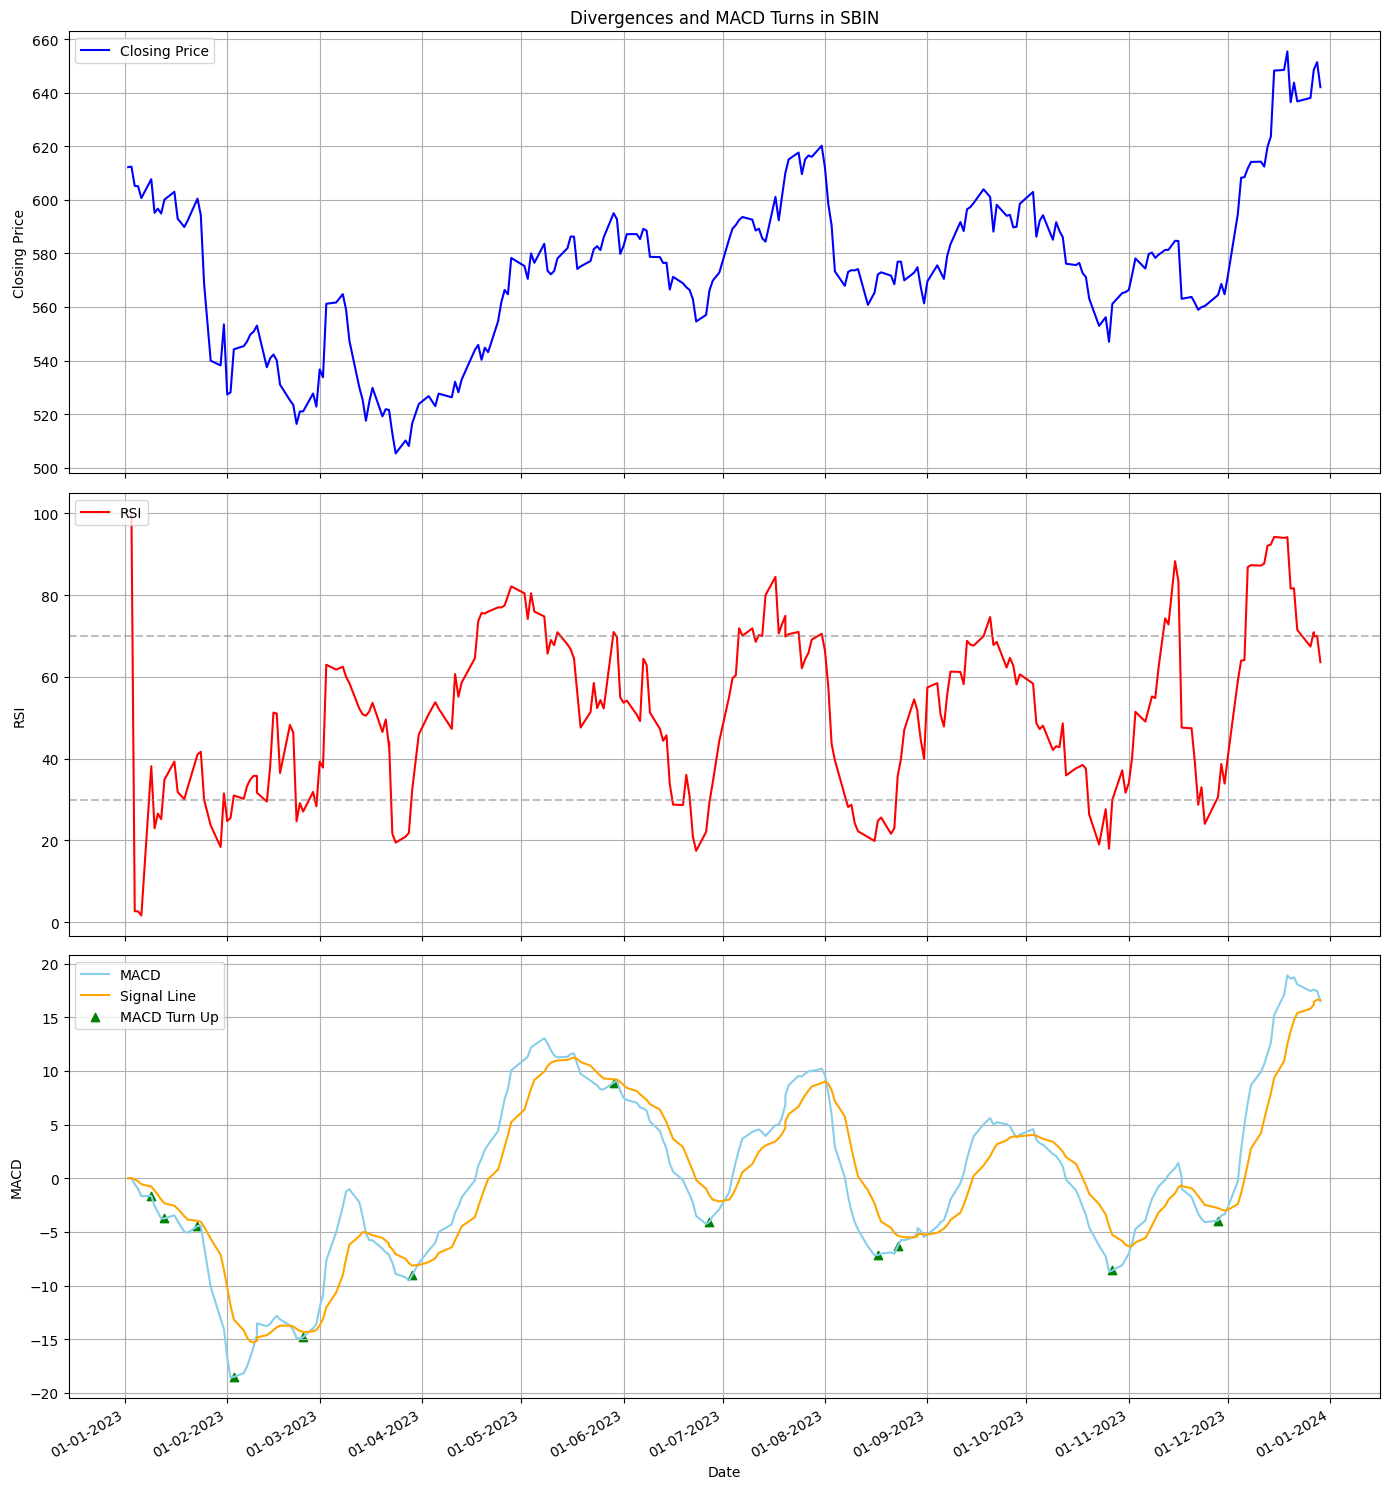

In [ ]:







































































































































































import nsepython as nse
import pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define symbols and series
symbol = input()
series = "EQ"
start_date = input()
end_date = input()

# Fetch equity history for the selected symbol
equity_data = nse.equity_history(symbol, series, start_date, end_date)
stock_df = pd.DataFrame(equity_data)
stock_df['mTIMESTAMP'] = pd.to_datetime(stock_df['mTIMESTAMP'])
stock_df = stock_df.sort_values(by='mTIMESTAMP')

# Convert necessary columns to numeric
stock_df['CH_CLOSING_PRICE'] = pd.to_numeric(stock_df['CH_CLOSING_PRICE'], errors='coerce')
stock_df['CH_OPENING_PRICE'] = pd.to_numeric(stock_df['CH_OPENING_PRICE'], errors='coerce')
stock_df['CH_TRADE_HIGH_PRICE'] = pd.to_numeric(stock_df['CH_TRADE_HIGH_PRICE'], errors='coerce')
stock_df['CH_TRADE_LOW_PRICE'] = pd.to_numeric(stock_df['CH_TRADE_LOW_PRICE'], errors='coerce')

# Drop rows with NaN values in key columns after conversion
stock_df = stock_df.dropna(subset=['CH_CLOSING_PRICE', 'CH_OPENING_PRICE', 'CH_TRADE_HIGH_PRICE', 'CH_TRADE_LOW_PRICE'])

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = pd.Series(data).diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# Calculate RSI
stock_df['RSI'] = calculate_rsi(stock_df['CH_CLOSING_PRICE'])

# Calculate MACD and Signal Line
stock_df['MACD'], stock_df['Signal_Line'] = calculate_macd(stock_df['CH_CLOSING_PRICE'])

# Identify points where MACD turns upwards below the Signal Line
macd_turn_up_points = []
for i in range(1, len(stock_df)):
    if (stock_df['MACD'][i] > stock_df['MACD'][i - 1] and
        stock_df['MACD'][i - 1] < stock_df['MACD'][i - 2] and
        stock_df['MACD'][i] < stock_df['Signal_Line'][i]):
        macd_turn_up_points.append((stock_df['mTIMESTAMP'][i], stock_df['RSI'][i], stock_df['MACD'][i]))

# Print identified MACD turn up points
print("MACD Turn Up Points (Date, RSI, MACD):")
for point in macd_turn_up_points:
    print(point)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

# Plot Closing Price
ax1.plot(stock_df['mTIMESTAMP'], stock_df['CH_CLOSING_PRICE'], label='Closing Price', color='blue')
ax1.set_ylabel('Closing Price')
ax1.set_title(f'Divergences and MACD Turns in {symbol}')
ax1.legend()
ax1.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

# Plot RSI
ax2.plot(stock_df['mTIMESTAMP'], stock_df['RSI'], label='RSI', color='red')
ax2.axhline(70, linestyle='--', alpha=0.5, color='gray')
ax2.axhline(30, linestyle='--', alpha=0.5, color='gray')
ax2.set_ylabel('RSI')
ax2.legend()
ax2.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()


# Plot MACD and Signal Line
ax3.plot(stock_df['mTIMESTAMP'], stock_df['MACD'], label='MACD', color='skyblue')
ax3.plot(stock_df['mTIMESTAMP'], stock_df['Signal_Line'], label='Signal Line', color='orange')
ax3.set_ylabel('MACD')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

# Highlight MACD turn up points on MACD plot
ax3.scatter([date for date, rsi, macd in macd_turn_up_points],
            [macd for date, rsi, macd in macd_turn_up_points],
            label='MACD Turn Up', marker='^', color='green')

# Add legends for divergences and MACD turns
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
turn_up_df = pd.DataFrame(macd_turn_up_points, columns=['Date', 'RSI', 'MACD'])
excel_file = f'{symbol}_MACD_Turn_Up_Points.xlsx'
turn_up_df.to_excel(excel_file, index=False)
print(f'MACD turn up points saved to {excel_file}')

MACD turn up points saved to SBIN_MACD_Turn_Up_Points.xlsx


SBIN
01-01-2023
31-12-2023
MACD Turn Down Points (Date, RSI, MACD):
(Timestamp('2023-02-10 00:00:00'), 35.77915001816196, -14.560753215159366)
(Timestamp('2023-02-17 00:00:00'), 36.51079136690645, -13.150299812533149)
(Timestamp('2023-03-13 00:00:00'), 52.250580046403726, -2.237804007150089)


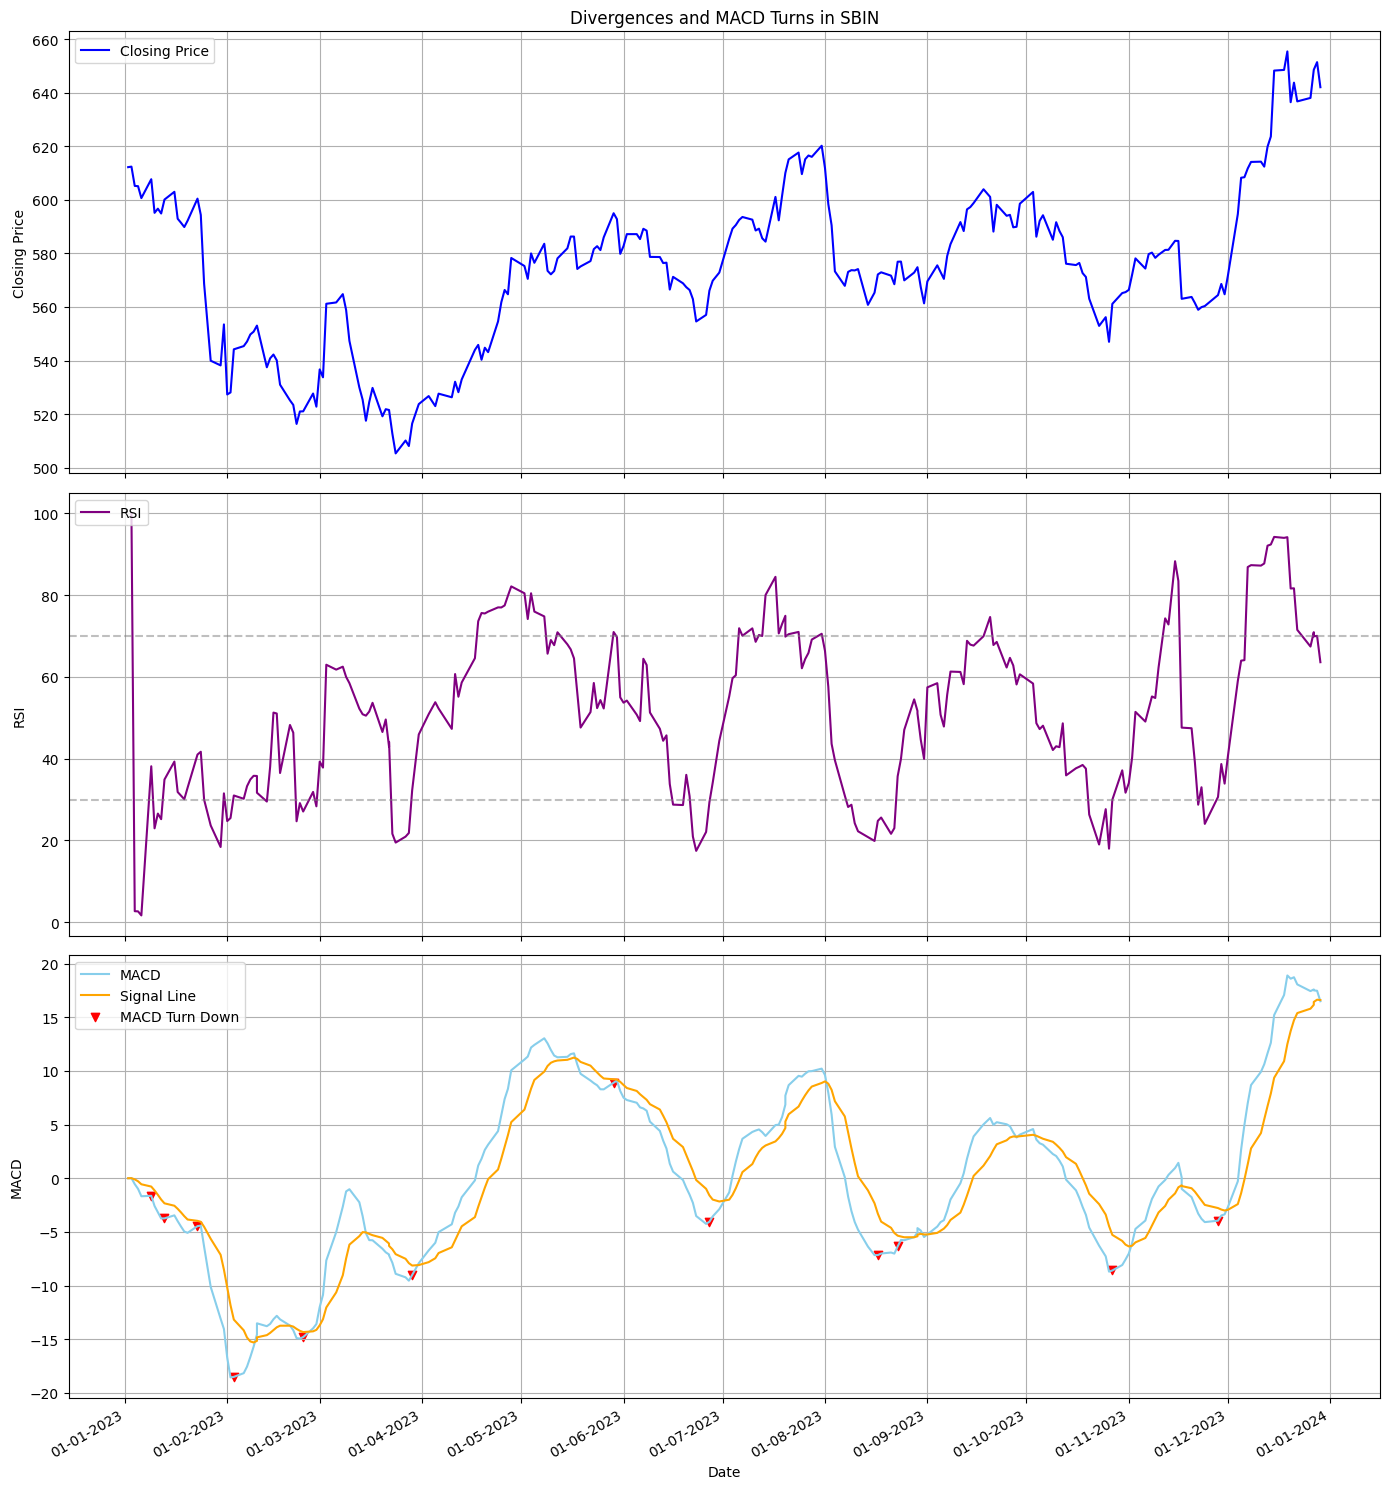

In [ ]:
import pandas as pd
import nsepython as nse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define symbols and series
symbol = input()
series = "EQ"
start_date = input()
end_date = input()

# Fetch equity history for the selected symbol
equity_data = nse.equity_history(symbol, series, start_date, end_date)
stock_df = pd.DataFrame(equity_data)
stock_df['mTIMESTAMP'] = pd.to_datetime(stock_df['mTIMESTAMP'])
stock_df = stock_df.sort_values(by='mTIMESTAMP')

# Convert necessary columns to numeric
stock_df['CH_CLOSING_PRICE'] = pd.to_numeric(stock_df['CH_CLOSING_PRICE'], errors='coerce')
stock_df['CH_OPENING_PRICE'] = pd.to_numeric(stock_df['CH_OPENING_PRICE'], errors='coerce')
stock_df['CH_TRADE_HIGH_PRICE'] = pd.to_numeric(stock_df['CH_TRADE_HIGH_PRICE'], errors='coerce')
stock_df['CH_TRADE_LOW_PRICE'] = pd.to_numeric(stock_df['CH_TRADE_LOW_PRICE'], errors='coerce')

# Drop rows with NaN values in key columns after conversion
stock_df = stock_df.dropna(subset=['CH_CLOSING_PRICE', 'CH_OPENING_PRICE', 'CH_TRADE_HIGH_PRICE', 'CH_TRADE_LOW_PRICE'])

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = pd.Series(data).diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# Calculate RSI
stock_df['RSI'] = calculate_rsi(stock_df['CH_CLOSING_PRICE'])

# Calculate MACD and Signal Line
stock_df['MACD'], stock_df['Signal_Line'] = calculate_macd(stock_df['CH_CLOSING_PRICE'])

# Identify points where MACD turns downward below zero line and is above Signal Line
macd_turn_down_points = []
for i in range(2, len(stock_df)):
    if (stock_df['MACD'][i] < stock_df['MACD'][i - 1] and
        stock_df['MACD'][i - 1] > stock_df['MACD'][i - 2] and
        stock_df['MACD'][i] > stock_df['Signal_Line'][i] and
        stock_df['MACD'][i] < 0):
        macd_turn_down_points.append((stock_df['mTIMESTAMP'][i], stock_df['RSI'][i], stock_df['MACD'][i]))



# Print identified MACD turn down points
print("MACD Turn Down Points (Date, RSI, MACD):")
for point in macd_turn_down_points:
    print(point)


# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

# Plot Closing Price
ax1.plot(stock_df['mTIMESTAMP'], stock_df['CH_CLOSING_PRICE'], label='Closing Price', color='blue')
ax1.set_ylabel('Closing Price')
ax1.set_title(f'Divergences and MACD Turns in {symbol}')
ax1.legend()
ax1.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

# Plot RSI
ax2.plot(stock_df['mTIMESTAMP'], stock_df['RSI'], label='RSI', color='purple')
ax2.axhline(70, linestyle='--', alpha=0.5, color='gray')
ax2.axhline(30, linestyle='--', alpha=0.5, color='gray')
ax2.set_ylabel('RSI')
ax2.legend()
ax2.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()


# Plot MACD and Signal Line
ax3.plot(stock_df['mTIMESTAMP'], stock_df['MACD'], label='MACD', color='skyblue')
ax3.plot(stock_df['mTIMESTAMP'], stock_df['Signal_Line'], label='Signal Line', color='orange')
ax3.set_ylabel('MACD')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

# Highlight MACD turn down points on MACD plot
ax3.scatter([date for date, rsi, macd in macd_turn_up_points],
            [macd for date, rsi, macd in macd_turn_up_points],
            label='MACD Turn Down', marker='v', color='red')



# Add legends for divergences and MACD turns
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
turn_down_df = pd.DataFrame(macd_turn_down_points, columns=['Date', 'RSI', 'MACD'])
excel_file = f'{symbol}_MACD_Turn_Down_Points.xlsx'
turn_up_df.to_excel(excel_file, index=False)
print(f'MACD turn down points saved to {excel_file}')

MACD turn down points saved to SBIN_MACD_Turn_Down_Points.xlsx
